## Algorithm to predict the size of the Yerba Mate grains

It is based in a photo of the grains disposed in a white paper. The algorithm can detect the contours and calculate the equivalent width and length of each grain. Then the distribution of the particle sizes is shown.

1. First the image is loaded and the cv2 library is used to process the image

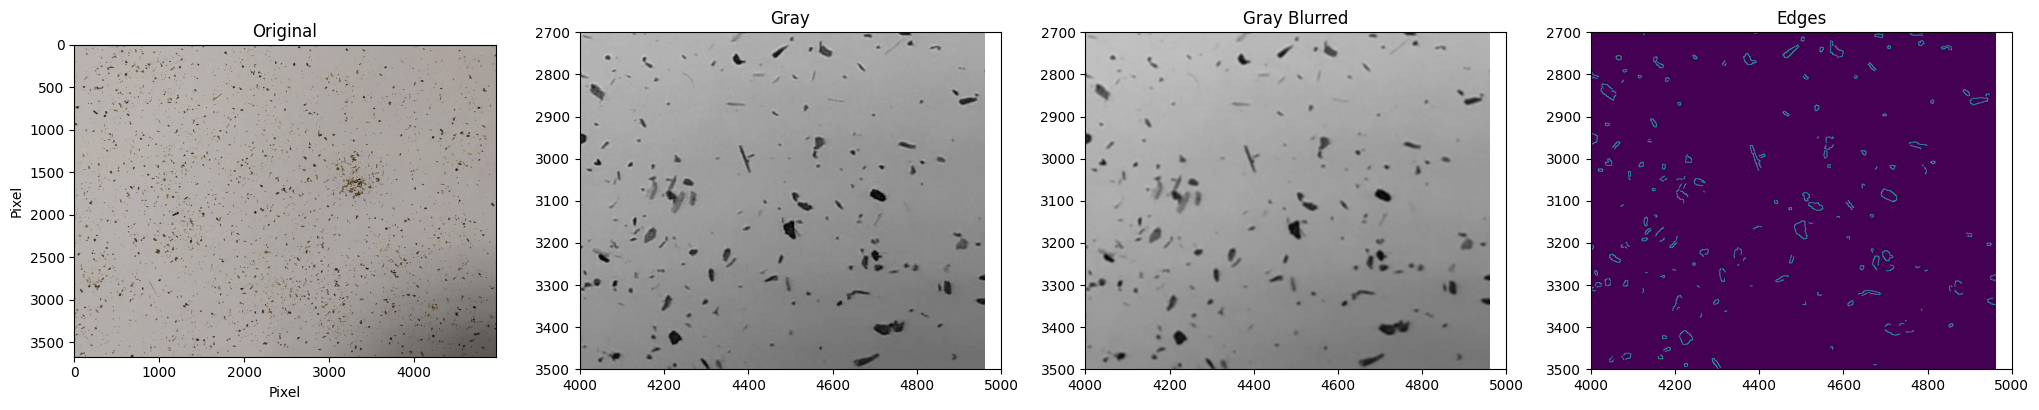

Hello


In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fname = 'YM2_extrafine_200x150.jpg'
img = cv.imread(fname) #YM_media3_2914x1758

#YM2_fine_150x100 --> 2684/150 = 17.89  ; 1768/100 = 17.68 resolution
#YM2_gruesa_200x150 --> 2454/200=12.27 ; 1826/150= 12.17
#YM2_extrafine_200x150 -->  5136/200 = 25.68 ; 3726/150 = 24.84

# Convert the image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


# Apply Gaussian blur to reduce noise
gray_blurred = cv.GaussianBlur(gray, (7, 7), 5)
img_edges = cv.Canny(gray,150,200)
#cv2.Canny

fig, axx = plt.subplots(1, 4, figsize=(25,10))
axx[0].imshow(img_rgb)
axx[1].imshow(gray, cmap='gray')
axx[2].imshow(gray_blurred, cmap='gray')
axx[3].imshow(img_edges)
#fig.suptitle('Yerba Mate extrafine granules')
axx[0].set_xlabel('Pixel')
axx[0].set_ylabel('Pixel')
axx[0].set_title('Original')
#axx[0].set_xlim(4000, 5000)
#axx[0].set_ylim(2500, 3500)

axx[1].set_title('Gray')
axx[1].set_xlim(4000, 5000)
axx[1].set_ylim(3500, 2700)

axx[2].set_title('Gray Blurred')
axx[2].set_xlim(4000, 5000)
axx[2].set_ylim(3500, 2700)

axx[3].set_title('Edges')
axx[3].set_xlim(4000, 5000)
axx[3].set_ylim(3500, 2700)
plt.show()
print('Hello')


In [2]:
#!pip install --upgrade pip
#!pip install opencv-python

#### Define the threshold of the image

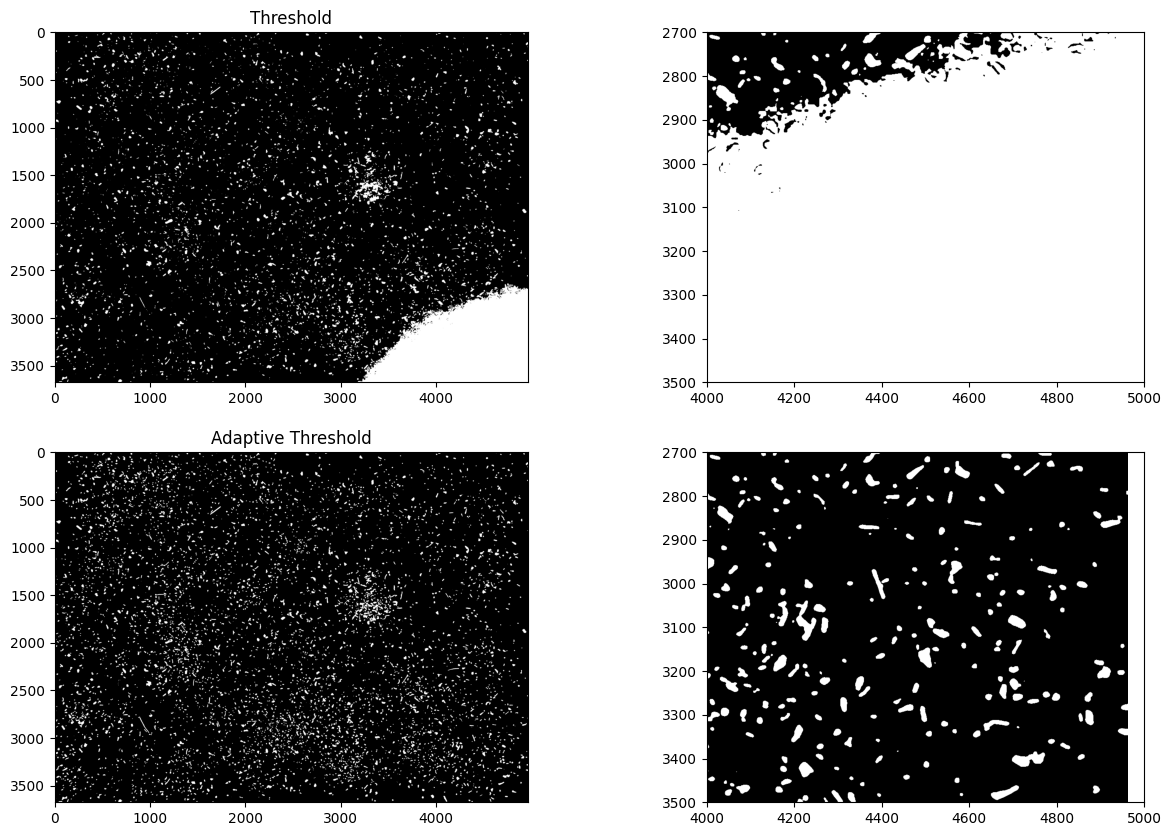

In [3]:
# Get the pixel resolution in pixels per millimeter (Enter valid values based on your image)
#pixel_resolution_x = float(input("Enter horizontal pixel resolution (pixels/mm): ")) #2234/100=22.34
#pixel_resolution_y = float(input("Enter vertical pixel resolution (pixels/mm): "))   #1358/60= 22.62

#YM2_extrafine_200x150.jpg (4975x3689 px)
pixel_resolution_x = 24.8
pixel_resolution_y = 24.6

# Apply thresholding to segment the sticks from the background
thresh = cv.threshold(gray_blurred, 100, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
thresh2 = cv.adaptiveThreshold(gray_blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 71,4) #Tune this last two numbers (odd values) to make the selection finer of coarser

fig, axx = plt.subplots(2, 2, figsize=(15,10))
axx[0][0].imshow(cv.cvtColor(thresh, cv.COLOR_BGR2RGB))
axx[0][0].set_title('Threshold')

axx[0][1].imshow(cv.cvtColor(thresh, cv.COLOR_BGR2RGB))
axx[0][1].set_xlim(4000, 5000)
axx[0][1].set_ylim(3500, 2700)

axx[1][0].imshow(cv.cvtColor(thresh2, cv.COLOR_BGR2RGB))
axx[1][0].set_title('Adaptive Threshold')

axx[1][1].imshow(cv.cvtColor(thresh2, cv.COLOR_BGR2RGB))
axx[1][1].set_xlim(4000, 5000)
axx[1][1].set_ylim(3500, 2700)

plt.show()


#### Find the contours of each grain

- with standard threshold
- with Addaptive threshold

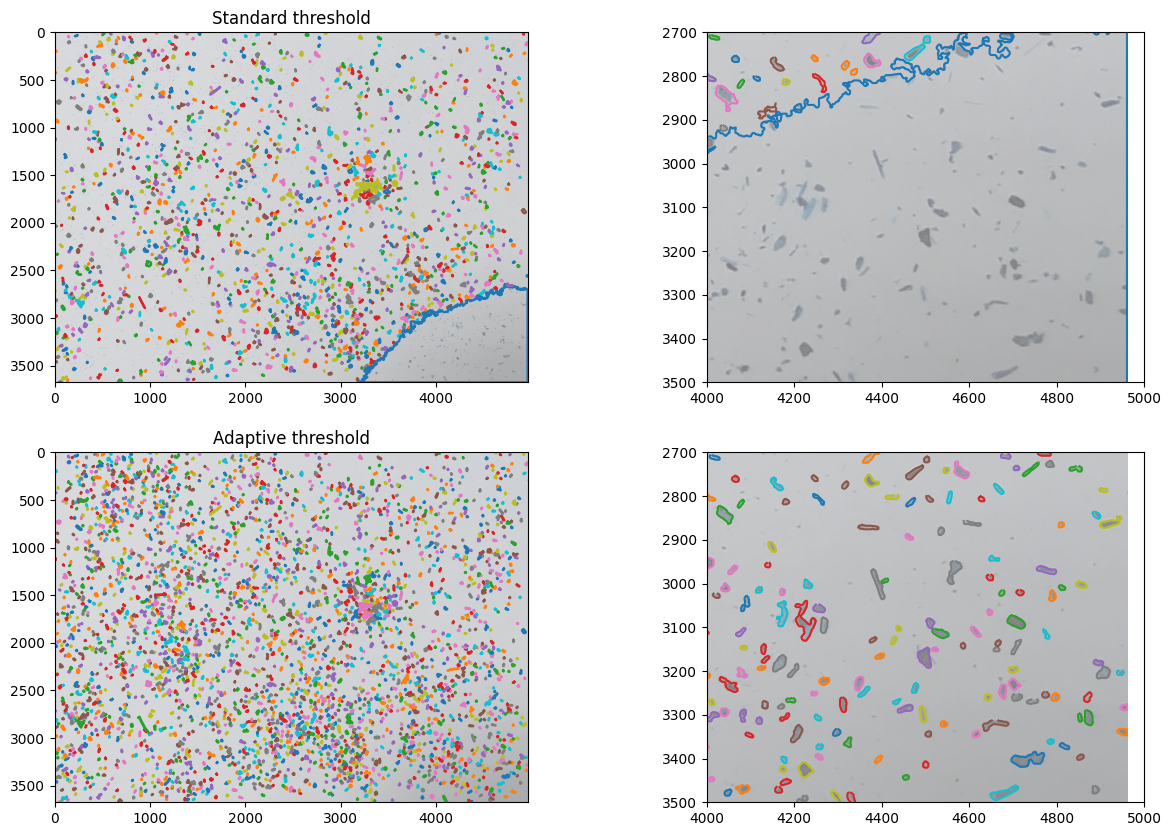

In [4]:
# Find contours of the sticks

contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours2, hierarchy2 = cv.findContours(thresh2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

fig, axx = plt.subplots(2, 2, figsize=(15,10))
colors = ['r', 'g', 'b', 'y', 'm']
for i, contour in enumerate(contours):
    area = cv.contourArea(contour)
    if area > 100:  # Only draw valid contours
        x, y = contour[:, :, 0].ravel(), contour[:, :, 1].ravel()
        axx[0][0].plot(x, y)
        axx[0][1].plot(x, y) 
axx[0][0].imshow(img, cmap='viridis', alpha=0.5)  # Overlay original image
axx[0][0].set_title('Standard threshold')
axx[0][1].imshow(img, cmap='viridis', alpha=0.5)  # Overlay original image
axx[0][1].set_xlim(4000, 5000)
axx[0][1].set_ylim(3500, 2700)

for i, contour in enumerate(contours2):
    area = cv.contourArea(contour)
    if area > 100:  # Only draw valid contours
        x, y = contour[:, :, 0].ravel(), contour[:, :, 1].ravel()
        axx[1][0].plot(x, y)
        axx[1][1].plot(x, y)
axx[1][0].imshow(img, cmap='viridis', alpha=0.5)  # Overlay original image
axx[1][0].set_title('Adaptive threshold')
axx[1][1].imshow(img, cmap='viridis', alpha=0.5)  # Overlay original image
axx[1][1].set_xlim(4000, 5000)
axx[1][1].set_ylim(3500, 2700)

plt.show()

#### Calculate the area of contours and equivalent width and length of the grains

In [5]:
#Selected threshold and contour
selected_threshold = thresh2
selected_contour = contours2

# Initialize lists to store stick dimensions
stick_lengths = []
stick_widths = []

# Loop through each contour (stick)
for contour in selected_contour:
    # Filter out small contours based on area (this threshold may need adjustment)
    area = cv.contourArea(contour)
    if area > 100:  # Minimum contour area to consider (pixels)
        # Calculate the bounding rectangle for the contour
        x, y, w, h = cv.boundingRect(contour)
        
        # Debugging: bounding rectangle position and size in pixels
        #print(f"Contour area: {area}, Width (px): {w}, Height (px): {h}")

        # Convert pixel dimensions to millimeters
        length = h / pixel_resolution_y  # Height in mm
        width = w / pixel_resolution_x    # Width in mm
        
        #Aca agregar que calcule el area de circunferencia equivalente de cada grano:
        
        # Append the stick dimensions to the lists
        stick_lengths.append(length)  # in mm
        stick_widths.append(width)    # in mm

len(stick_lengths)

3062

#### Create a DataFrame

In [6]:
dict_dimensions = {'length': stick_lengths, 'width': stick_widths}

df_grains = pd.DataFrame(dict_dimensions)
df_grains.head()

#Add granulometry to dataframe
df_grains['granulometry'] = 'extrafine'

df_grains.to_csv(f'dimensions_{fname}.csv', index=False)

#Calculate mean values and standard deviation

length_mean = round(df_grains['length'].mean(), 2)
length_dev = round(df_grains['length'].std(), 2)

width_mean = round(df_grains['width'].mean(), 2)
width_dev = round(df_grains['width'].std(), 2)

df_grains['length'].size

3062

#### Plot the results

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

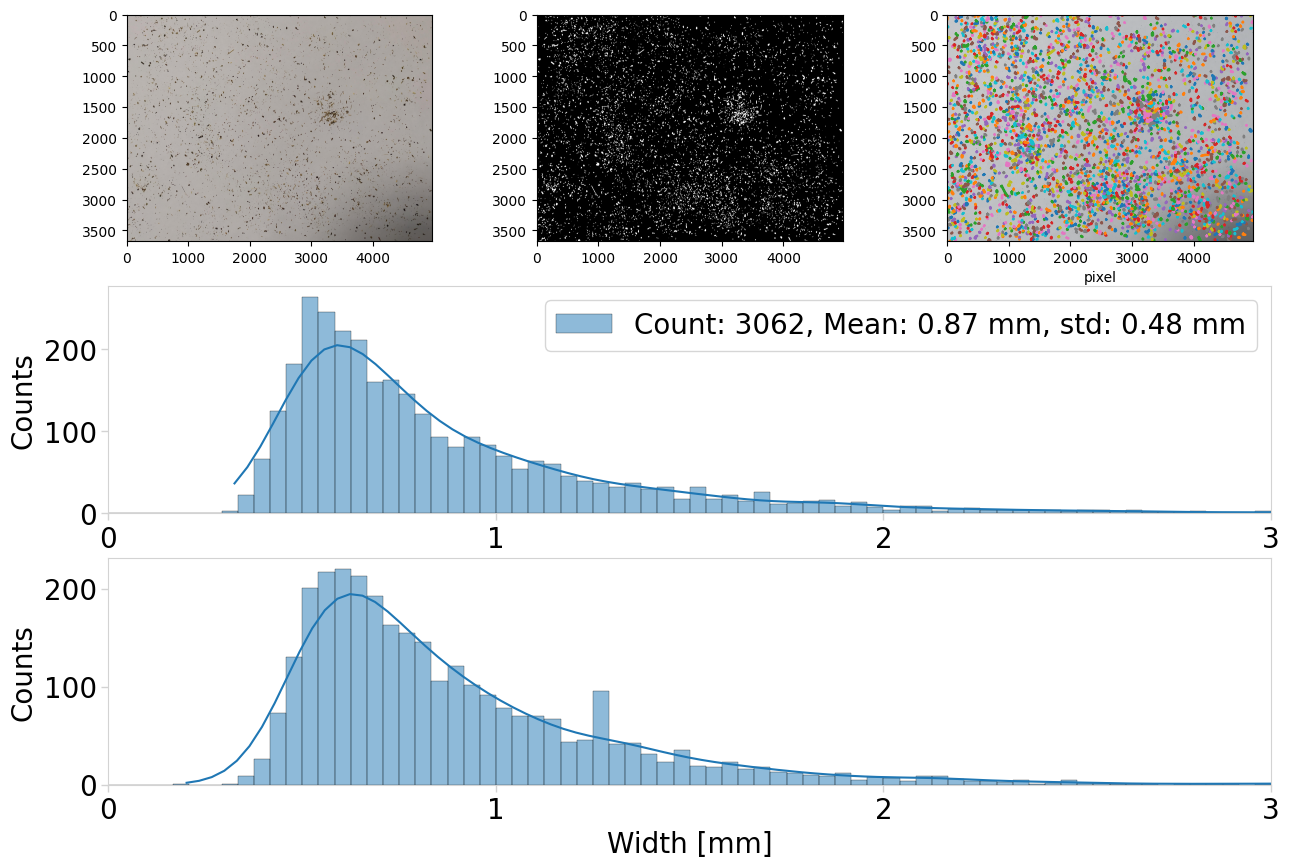

In [ ]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(3,3, figure=fig)

ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,-2])
ax3=fig.add_subplot(gs[0,-1])
ax4=fig.add_subplot(gs[1,:])
ax5=fig.add_subplot(gs[2,:])

ax1.imshow(img_rgb, cmap='gray')
ax2.imshow(selected_threshold, cmap='gray')
ax3.imshow(gray, cmap='gray')

for i, contour in enumerate(selected_contour):
    area = cv.contourArea(contour)
    if area > 100:  # Only draw valid contours
        x, y = contour[:, :, 0].ravel(), contour[:, :, 1].ravel()
        ax3.plot(x, y)
ax3.imshow(img, cmap='viridis', alpha=0.5)  # Overlay original image
ax3.set_xlabel('pixel')
#ax3.set_ylabel('pixel')

bin_edges = np.linspace(0, 15, 361)
fontsize=16
count = df_grains['length'].size

sns.histplot(data=df_grains, ax=ax4, x='length', bins=bin_edges, kde=True, log_scale=False, label=f'Count: {count}, Mean: {length_mean} mm, std: {length_dev} mm') 
#sns.histplot(data=clustered_sticks[1], ax=ax4, x='length', bins=30, kde=True, log_scale=False, label=f'Mean: {round(np.array(clustered_sticks[1]["length"]).mean(), 2)} mm, std: {round(np.array(clustered_sticks[1]["length"]).std(), 2)} mm') 
#sns.jointplot(data=df, x="length", y="width")
ax4.set_xlabel('Length [mm]', fontsize=fontsize)
ax4.set_ylabel('Counts', fontsize=fontsize)
xlabels=np.arange(0,30,1)
ax4.set_xticks(xlabels)
ax4.tick_params(axis ='both', length=5, width=1, color='lightgray', labelsize=fontsize) 
ax4.set_xlim(0, 3)
for spine in ax4.spines.values():
    spine.set_color('lightgrey')  # Change spine color to light grey
ax4.legend(fontsize=fontsize)




sns.histplot(data=df_grains, ax=ax5, x='width', bins=bin_edges, kde=True, log_scale=False, label=f'Count: {count}, Mean: {width_mean} mm, std: {width_dev} mm')
#sns.histplot(data=clustered_sticks[1], ax=ax5, x='width', bins=30, kde=True, log_scale=False, label=f'Mean: {round(np.array(clustered_sticks[1]["width"]).mean(), 2)} mm, std: {round(np.array(clustered_sticks[1]["width"]).std(), 2)} mm')
ax5.set_xlabel('Width [mm]', fontsize=fontsize)
ax5.set_ylabel('Counts', fontsize=fontsize)
ax5.set_xticks(xlabels)
ax5.tick_params(axis ='both', length=5, width=1, color='lightgray', labelsize=fontsize)
ax5.set_xlim(0, 3)
for spine in ax5.spines.values():
    spine.set_color('lightgrey')  # Change spine color to light grey

plt.tight_layout(pad=0.5)
ax5.legend(fontsize=fontsize)

plt.show()

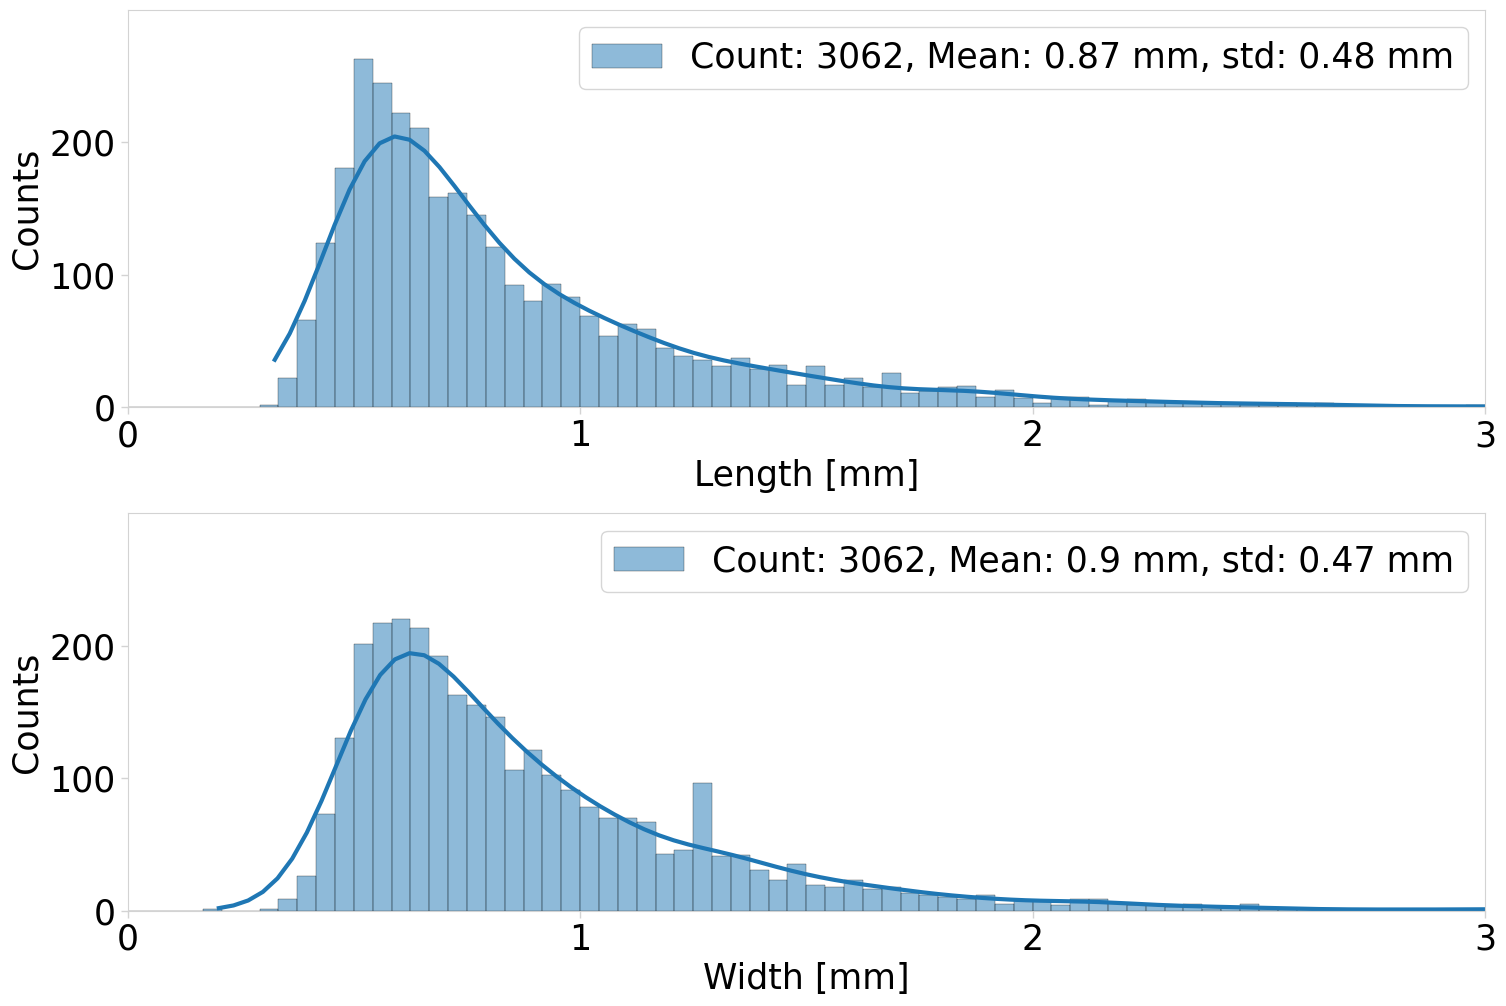

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))

bin_edges = np.linspace(0, 15, 361)
fontsize=25
count = df_grains['length'].size

sns.histplot(data=df_grains, ax=ax[0], x='length', bins=bin_edges, kde=True, line_kws={'linewidth': 3}, log_scale=False, label=f'Count: {count}, Mean: {length_mean} mm, std: {length_dev} mm') 
#sns.histplot(data=clustered_sticks[1], ax=ax4, x='length', bins=30, kde=True, log_scale=False, label=f'Mean: {round(np.array(clustered_sticks[1]["length"]).mean(), 2)} mm, std: {round(np.array(clustered_sticks[1]["length"]).std(), 2)} mm') 
#sns.jointplot(data=df, x="length", y="width")
ax[0].set_xlabel('Length [mm]', fontsize=fontsize)
ax[0].set_ylabel('Counts', fontsize=fontsize)
xlabels=np.arange(0,30,1)
ax[0].set_xticks(xlabels)
ax[0].tick_params(axis ='both', length=5, width=1, color='lightgray', labelsize=fontsize) 
ax[0].set_xlim(0, 3)
ax[0].set_ylim(0, 300)
for spine in ax[0].spines.values():
    spine.set_color('lightgrey')  # Change spine color to light grey
ax[0].legend(fontsize=fontsize)
ax[0].set_yticks([0, 100, 200])



sns.histplot(data=df_grains, ax=ax[1], x='width', bins=bin_edges, kde=True, line_kws={"linewidth": 3}, log_scale=False, label=f'Count: {count}, Mean: {width_mean} mm, std: {width_dev} mm')
#sns.histplot(data=clustered_sticks[1], ax=ax5, x='width', bins=30, kde=True, log_scale=False, label=f'Mean: {round(np.array(clustered_sticks[1]["width"]).mean(), 2)} mm, std: {round(np.array(clustered_sticks[1]["width"]).std(), 2)} mm')
ax[1].set_xlabel('Width [mm]', fontsize=fontsize)
ax[1].set_ylabel('Counts', fontsize=fontsize)
ax[1].set_xticks(xlabels)
ax[1].tick_params(axis ='both', length=5, width=1, color='lightgray', labelsize=fontsize)
ax[1].set_xlim(0, 3)
ax[1].set_ylim(0, 300)
for spine in ax[1].spines.values():
    spine.set_color('lightgrey')  # Change spine color to light grey

plt.tight_layout(pad=0.5)
ax[1].legend(fontsize=fontsize)
ax[1].set_yticks([0, 100, 200])

plt.show()

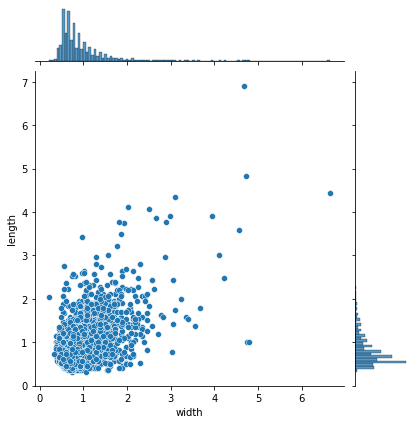

In [8]:
sns.jointplot(data=df_grains, x='width', y='length')

### Some GIT commands

- cd ~/projects/my_notebooks      -->   Navigate to the notebook directory
- code my_notebook.ipynb           --> Open the notebook in VS Code


- git add my_notebook.ipynb    -->     # Stage the changes
- git commit -m "Updated analysis"  --> # Commit the changes
- git push origin main           -->    # Push changes to the main branch (if needed)
- git rm file/path --> remove path

- In WLS:   The Windows drive letters (like C:) are mapped to /mnt/c in WSL. 
- ls /mnt/c/  --> to access the disk
- cd /mnt/c/Users/YourUsername/Pictures --> or navigate to path 

\
- In PowerShell:\
$path = path \
$path -replace  '\\\\', '/' \
asdfs